In [417]:
import pandas as pd
import numpy as np
import seaborn as sns

In [418]:
pd.set_option("display.max_columns", None)
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [419]:
dfPolicyData = pd.read_csv("PolicyData.csv", delimiter = ";", encoding='latin-1')
dfPolicyData.set_index("policy_guid", inplace = True)

dfInvoiceData = pd.read_csv("InvoiceData.csv", delimiter = ";")
dfInvoiceData.set_index("invoice_guid", inplace = True)


In [420]:
# 1: Invoice is paid late
# 0: Invoice is not paid late
aLabels = [1, 0]
aConditions = [
    (dfInvoiceData["due_date"] < dfInvoiceData["paid_date"]),
    (dfInvoiceData["due_date"] >= dfInvoiceData["paid_date"])
]

dfInvoiceData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [421]:
# In the dataset not all policies are ended. It s a snapshot probably around June 2018.
# There could be 3 status of policies: "Ended on time", "Terminated" and "Ongoing"
# We can build model not based on policy status, but based on number of issued invoices.

oInvocieGroupByPolicy = dfInvoiceData[["policy_guid", "is_it_paid_late"]].groupby(["policy_guid"])

dfInvoiceIssueStatistics = oInvocieGroupByPolicy.agg(["count", "sum"])

dfInvoiceIssueStatistics = dfInvoiceIssueStatistics["is_it_paid_late"] 

dfInvoiceIssueStatistics.columns = ["number_of_invoices", "number_of_late_payments"]

dfInvoiceIssueStatistics["late_payment_ratio"] = dfInvoiceIssueStatistics["number_of_late_payments"]/dfInvoiceIssueStatistics["number_of_invoices"]


dfPolicyData = dfPolicyData.join(dfInvoiceIssueStatistics)

In [422]:
# 1: Policy is paid late at least once
# 0: Policy is never paid late
aLabels = [1, 0]
aConditions = [
    (dfPolicyData["number_of_late_payments"] >= 1),
    (dfPolicyData["number_of_late_payments"] == 0)
]

dfPolicyData["is_it_paid_late"] = np.select(aConditions, aLabels)

In [423]:
# 1: Policy is still active
# 0: Policy is ended or terminated
dfPolicyData["is_policy_active"] = 0

dfPolicyData.loc[(dfPolicyData["number_of_invoices"] < dfPolicyData["Nb_of_payments"]) & (dfPolicyData["Terminated"] == 0), "is_policy_active"] = 1


In [424]:
# They are converted from object to float
dfInvoiceData["amount_premium"] = dfInvoiceData["amount_premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')
dfPolicyData["Premium"] = dfPolicyData["Premium"].apply(lambda x: x.replace(',','.'), ).astype(float, errors = 'raise')

dfPolicyData.info()
dfInvoiceData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68638 entries, {E4FD3CD8-4141-4E55-A74C-C983ED7EFD8E} to {81D48EF2-6ED1-4784-AE0C-9481151186F9}
Data columns (total 43 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       68638 non-null  object 
 1   VehicleType                   68638 non-null  object 
 2   VehicleUsage                  68638 non-null  object 
 3   Power                         68638 non-null  int64  
 4   Weight                        68638 non-null  int64  
 5   VehicleFirstRegistrationYear  68638 non-null  int64  
 6   Mark                          68638 non-null  object 
 7   Model                         68638 non-null  object 
 8   Deductible_general            68636 non-null  float64
 9   Fire                          68638 non-null  int64  
 10  Theft                         68638 non-null  int64  
 11  Natural_disasters             68638 non-null  int64  


In [425]:
# Columns that are NaN or 'Missing' in policy dataset

dfPolicyData.columns[dfPolicyData.isna().any()].tolist()

dfMissing = dfPolicyData.astype(str) == "Missing"
dfPolicyData.columns[dfMissing.any()].tolist()


['Deductible_general', 'ClientBirthday', 'BMClassMOD', 'avgFuelConsumption']

['Region', 'FuelType', 'DriveTrain']

In [426]:
# Columns that are NaN or 'Missing' in invoice dataset.
# There is no missing data invoice dataset. 

dfInvoiceData.columns[dfInvoiceData.isna().any()].tolist()

dfMissing = dfInvoiceData.astype(str) == "Missing"
dfInvoiceData.columns[dfMissing.any()].tolist()

[]

[]

In [427]:
# There are policies where number of invoices are greater than number of issued invoices.
dfToQuestion = dfPolicyData[dfPolicyData["number_of_invoices"] > dfPolicyData["Nb_of_payments"]].loc[:, ["number_of_invoices", "Nb_of_payments"]]

MISSING DATA MANUPULATIONS

Deductible_general:

There are only 2 rows where Deductible_general is missing. 

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [428]:
dfMissingDecutibleGeneral = dfPolicyData[dfPolicyData["Deductible_general"].isna()]
dfPolicyData.drop(dfMissingDecutibleGeneral.index, inplace = True)

ClientBirthday:
    
There are only 43 rows where ClientBirthday is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [429]:
dfMissingClientBirthday = dfPolicyData[dfPolicyData["ClientBirthday"].isna()]
dfPolicyData.drop(dfMissingClientBirthday.index, inplace = True)

BMClassMOD:

There are only 14 rows where BMClassMOD is missing.

Since they are relatively small amount of rows for this dataset, these rows are deleted.

In [430]:
dfMissingBmClassMod = dfPolicyData[dfPolicyData["BMClassMOD"].isna()]
dfPolicyData.drop(dfMissingBmClassMod.index, inplace = True)

avgFuelConsumption:

There are 27927 rows where avgFuelConsumption is missing.
Since it s a big amount of rows, correlation between avgFuelConsumption and late payment are investigated for the non-missing avgFuelConsumption.

As it can be seen from heatmap, correlation coefficient is not even 0.10 which implies weak relationship between late payment attributes.

Due to high amount of missing and weak correlation, this field is excluded from policy dataset.

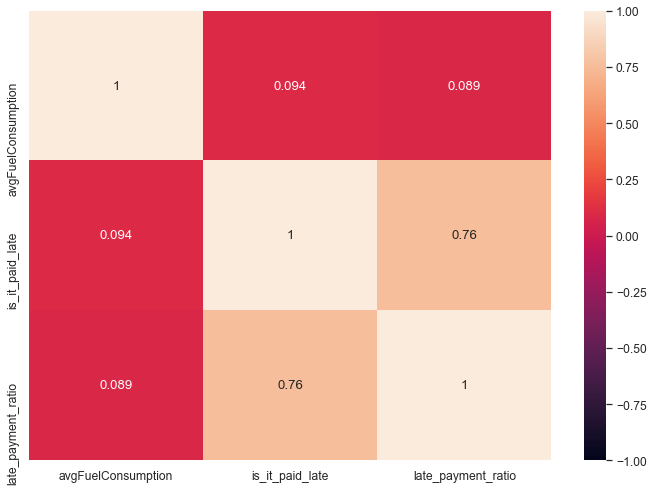

In [431]:
dfMissingAvgFuelConsumption = dfPolicyData[dfPolicyData["avgFuelConsumption"].isna()]
dfNonMissingAvgFuelConsumption = dfPolicyData.drop(dfMissingAvgFuelConsumption.index, inplace = False)

dfCorr = dfNonMissingAvgFuelConsumption[["avgFuelConsumption", "is_it_paid_late", "late_payment_ratio"]].corr()

sns.heatmap(dfCorr, vmin=-1, vmax=1, annot=True)
